imports

In [13]:
import random
from datetime import datetime,timedelta
import csv
from faker import Faker
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import graphviz

## Goal: generate a list of task with the people on it and the deadline of each task

### First let's just try to determine the duration of a task

As no dataset lets generate our own one

In [14]:
#task : desc,type,deadline,technologies,team,duration(the output that we try to guess)
#start: date of the task creation
#type : "bug", "feature", "refactor", "test", "documentation"
#technologies : "python", "java", "c++", "c#", "javascript", "ruby", "php", "html", "css", "sql", "nosql"
#team : number of people in the team
#priority : 0,1,2(0 :"low", 1:"medium", 2:"high")
#duration : in days
#deadline : a date in the future
#desc : a string

#generate a random but credible dataset of task

def generate_dataset(sample):
    
    fake = Faker()
    tasks = []
    for i in range(sample):
        min_duration = 1
        task = {}
        task["desc"] = fake.text()
        task["type"] = random.choice(["bug", "feature", "refactor", "test", "documentation"])
        task["start"] = (datetime.now()+ timedelta(days=random.randint(0,3))).strftime("%Y-%m-%d")
        #documentation tasks are only about documentation
        if task["type"] == "documentation":
            task["technologies"] = ["doc"]
        else:
            task["technologies"] = random.sample(["python", "java", "c++", "c#", "web", "sql", "nosql"], k=1)
            # task["technologies"] = random.sample(["python", "java", "c++", "c#", "web", "sql", "nosql",], k=random.randint(1, 2))
        max_team = 10
        task["team"] = random.randint(1, max_team)
        task["priority"] = random.randint(0, 2)
        min_duration += max_team - task["team"] #more people = less time
        if "c++" in task["technologies"]:
            min_duration += 1 #because c++ you know...
        if "documentation" not in task["type"]:
            min_duration += 5 #documentation is easier
        if len(task["desc"]) > 100:
            min_duration += len(task["desc"])//30 #we can imagine than longer description = more time
        
        
        #task["deadline"] should be at least min_duration days in the future
        start_date = datetime.now()
        min_deadline_date = start_date + timedelta(days=min_duration)
        #max_deadline change with the priority
        if task["priority"] == 0:
            max_duration = min_duration + 15 #low priority tasks are less urgent
        elif task["priority"] == 1:
            max_duration = min_duration + 10
        else:
            max_duration = min_duration + 5 #high priority tasks are more urgent
        max_deadline_date = start_date + timedelta(days=max_duration)
        task["deadline"] = fake.date_time_between_dates(datetime_start=min_deadline_date, datetime_end=max_deadline_date).strftime("%Y-%m-%d")
        task["duration"] = random.randint(min_duration, max_duration)
        tasks.append(task)
    with open("./data/tasks.csv", "w") as f:
        writer = csv.DictWriter(f, fieldnames=["desc", "type", "start","deadline", "technologies", "team","priority", "duration"])
        writer.writeheader()
        for task in tasks:
            writer.writerow(task)
    return tasks

generate_dataset(5000)

[{'desc': 'Trade scientist do officer able side. Bed speech travel ball model.\nRemember magazine enter focus find. Pm bill tell. Analysis project long door both end.',
  'type': 'test',
  'start': '2024-11-14',
  'technologies': ['sql'],
  'team': 7,
  'priority': 1,
  'deadline': '2024-11-29',
  'duration': 17},
 {'desc': 'Single information particularly few onto natural. Dream nearly well amount civil quickly marriage.\nChance break young. Between send Democrat at with painting.',
  'type': 'test',
  'start': '2024-11-13',
  'technologies': ['c#'],
  'team': 7,
  'priority': 2,
  'deadline': '2024-11-29',
  'duration': 19},
 {'desc': 'Dark site hundred project. Standard knowledge word soldier. Senior work us understand strategy person. Front result return knowledge local soon.',
  'type': 'bug',
  'start': '2024-11-12',
  'technologies': ['web'],
  'team': 10,
  'priority': 2,
  'deadline': '2024-11-26',
  'duration': 11},
 {'desc': 'Analysis ask water. Economic no run kid bag begin

### explore the dataset

In [15]:
df = pd.read_csv("./data/tasks.csv")	
df.describe()

,team,priority,duration
count,5000.000000,5000.000000,5000.000000
mean,5.532000,1.015800,18.625200
std,2.881152,0.813193,5.620271
min,1.000000,0.000000,1.000000
25%,3.000000,0.000000,15.000000
50%,6.000000,1.000000,19.000000
75%,8.000000,2.000000,22.000000
max,10.000000,2.000000,36.000000


encoded data

In [16]:
df_encoded = df.copy()



#encode the type (one to many)
df_encoded = pd.get_dummies(df_encoded, columns=["type"])

#encode the technologies (many to many)
df_encoded = pd.get_dummies(df_encoded, columns=["technologies"])

#encode the start date
df_encoded['start'] = pd.to_datetime(df_encoded['start'])
df_encoded['start'] = df_encoded['start'].map(datetime.toordinal)
#encode the deadline
df_encoded['deadline'] = pd.to_datetime(df_encoded['deadline'])
df_encoded['deadline'] = df_encoded['deadline'].map(datetime.toordinal)

#ensure the numeric value of start and deadline

df_encoded['start'] = pd.to_numeric(df_encoded['start'])
df_encoded['deadline'] = pd.to_numeric(df_encoded['deadline'])

df_encoded

,desc,start,deadline,team,priority,duration,type_bug,type_documentation,type_feature,type_refactor,type_test,technologies_['c#'],technologies_['c++'],technologies_['doc'],technologies_['java'],technologies_['nosql'],technologies_['python'],technologies_['sql'],technologies_['web']
0,Trade scientist do officer able side. Bed spee...,739204,739219,7,1,17,False,False,False,False,True,False,False,False,False,False,False,True,False
1,Single information particularly few onto natur...,739203,739219,7,2,19,False,False,False,False,True,True,False,False,False,False,False,False,False
2,Dark site hundred project. Standard knowledge ...,739202,739216,10,2,11,True,False,False,False,False,False,False,False,False,False,False,False,True
3,Analysis ask water. Economic no run kid bag be...,739204,739220,3,2,23,True,False,False,False,False,False,False,False,False,False,True,False,False
4,High light money section might least. I who of...,739204,739217,8,0,28,False,False,False,True,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,State number discuss benefit feel occur. Choic...,739204,739209,8,2,11,False,True,False,False,False,False,False,True,False,False,False,False,False
4996,Plant wait major enough decade yes single oil....,739202,739220,5,1,19,False,False,True,False,False,False,False,False,False,True,False,False,False
4997,Network either country face available. Includi...,739201,739220,6,2,18,True,False,False,False,False,False,True,False,False,False,False,False,False
4998,Very think sort road second. Garden try econom...,739204,739216,4,2,15,False,True,False,False,False,False,False,True,False,False,False,False,False


                            start  deadline      team  priority  duration  \
start                    1.000000  0.038059 -0.011928  0.004557  0.019276   
deadline                 0.038059  1.000000 -0.527918 -0.388021  0.648621   
team                    -0.011928 -0.527918  1.000000  0.018184 -0.505102   
priority                 0.004557 -0.388021  0.018184  1.000000 -0.373498   
duration                 0.019276  0.648621 -0.505102 -0.373498  1.000000   
type_bug                 0.016926  0.096391 -0.016482  0.009215  0.098796   
type_documentation      -0.025476 -0.374163 -0.003942 -0.005480 -0.377384   
type_feature            -0.027423  0.092005  0.000776  0.011388  0.090747   
type_refactor           -0.008471  0.083970  0.006408  0.002179  0.085735   
type_test                0.044012  0.103240  0.013293 -0.017145  0.103557   
technologies_['c#']     -0.008328  0.055529 -0.012774 -0.007630  0.060857   
technologies_['c++']    -0.002950  0.131019 -0.020010 -0.016259  0.152805   

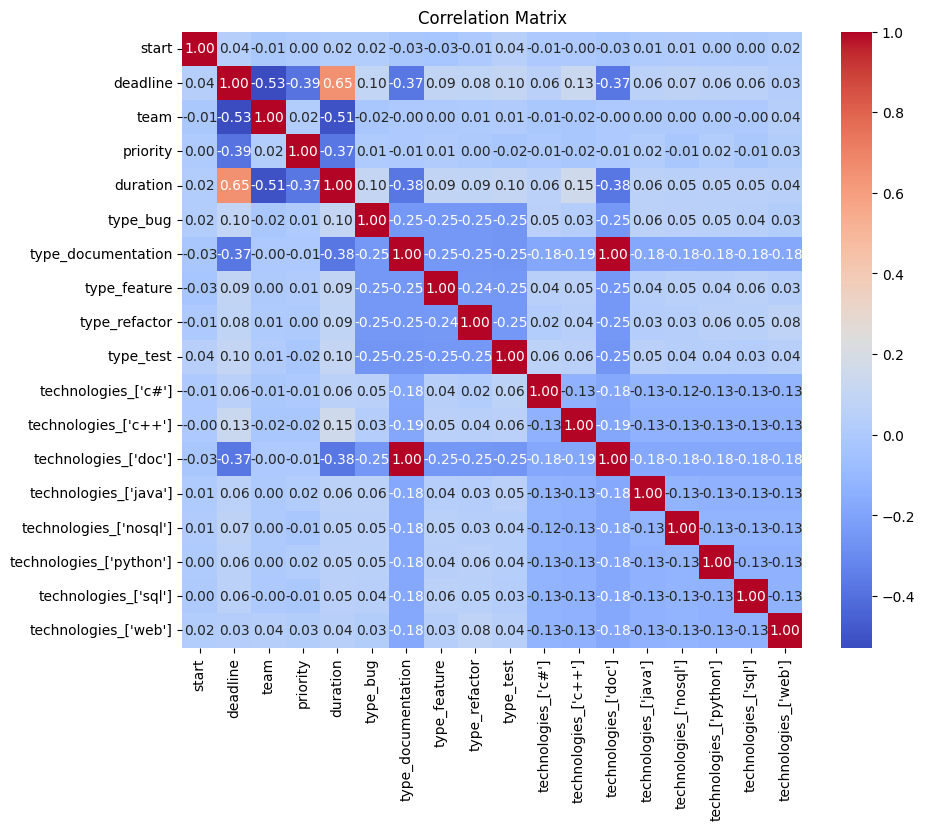

In [17]:
#correlation matrix
df_without_desc  = df_encoded.drop(columns=["desc"]) #cause too hard for the correlation matrix to generate
corr_matrix = df_without_desc.corr()
print(corr_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix,annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

correlation with the output

In [18]:
#correlation between every feature and the duration
correlation = corr_matrix["duration"].sort_values(ascending=False)
correlation = correlation[correlation.index != "duration"]
print(correlation)

deadline                   0.648621
technologies_['c++']       0.152805
type_test                  0.103557
type_bug                   0.098796
type_feature               0.090747
type_refactor              0.085735
technologies_['c#']        0.060857
technologies_['java']      0.058962
technologies_['python']    0.054718
technologies_['sql']       0.053825
technologies_['nosql']     0.049719
technologies_['web']       0.043470
start                      0.019276
priority                  -0.373498
technologies_['doc']      -0.377384
type_documentation        -0.377384
team                      -0.505102
Name: duration, dtype: float64


### Try a model to determine the duration

Decision Tree Regression

Best parameters :  {'max_depth': 10, 'min_samples_leaf': 30, 'min_samples_split': 2}
Final RMSE :  3.820863776687151
Final RMSE scores :  [3.90288355 3.79308582 3.7729299  3.95253083 3.86296518 4.06755455
 3.64177155 3.88297566 3.86005181 4.01154584]
Final RMSE scores mean :  3.874829468521407
Final RMSE scores std :  0.11595943203598708


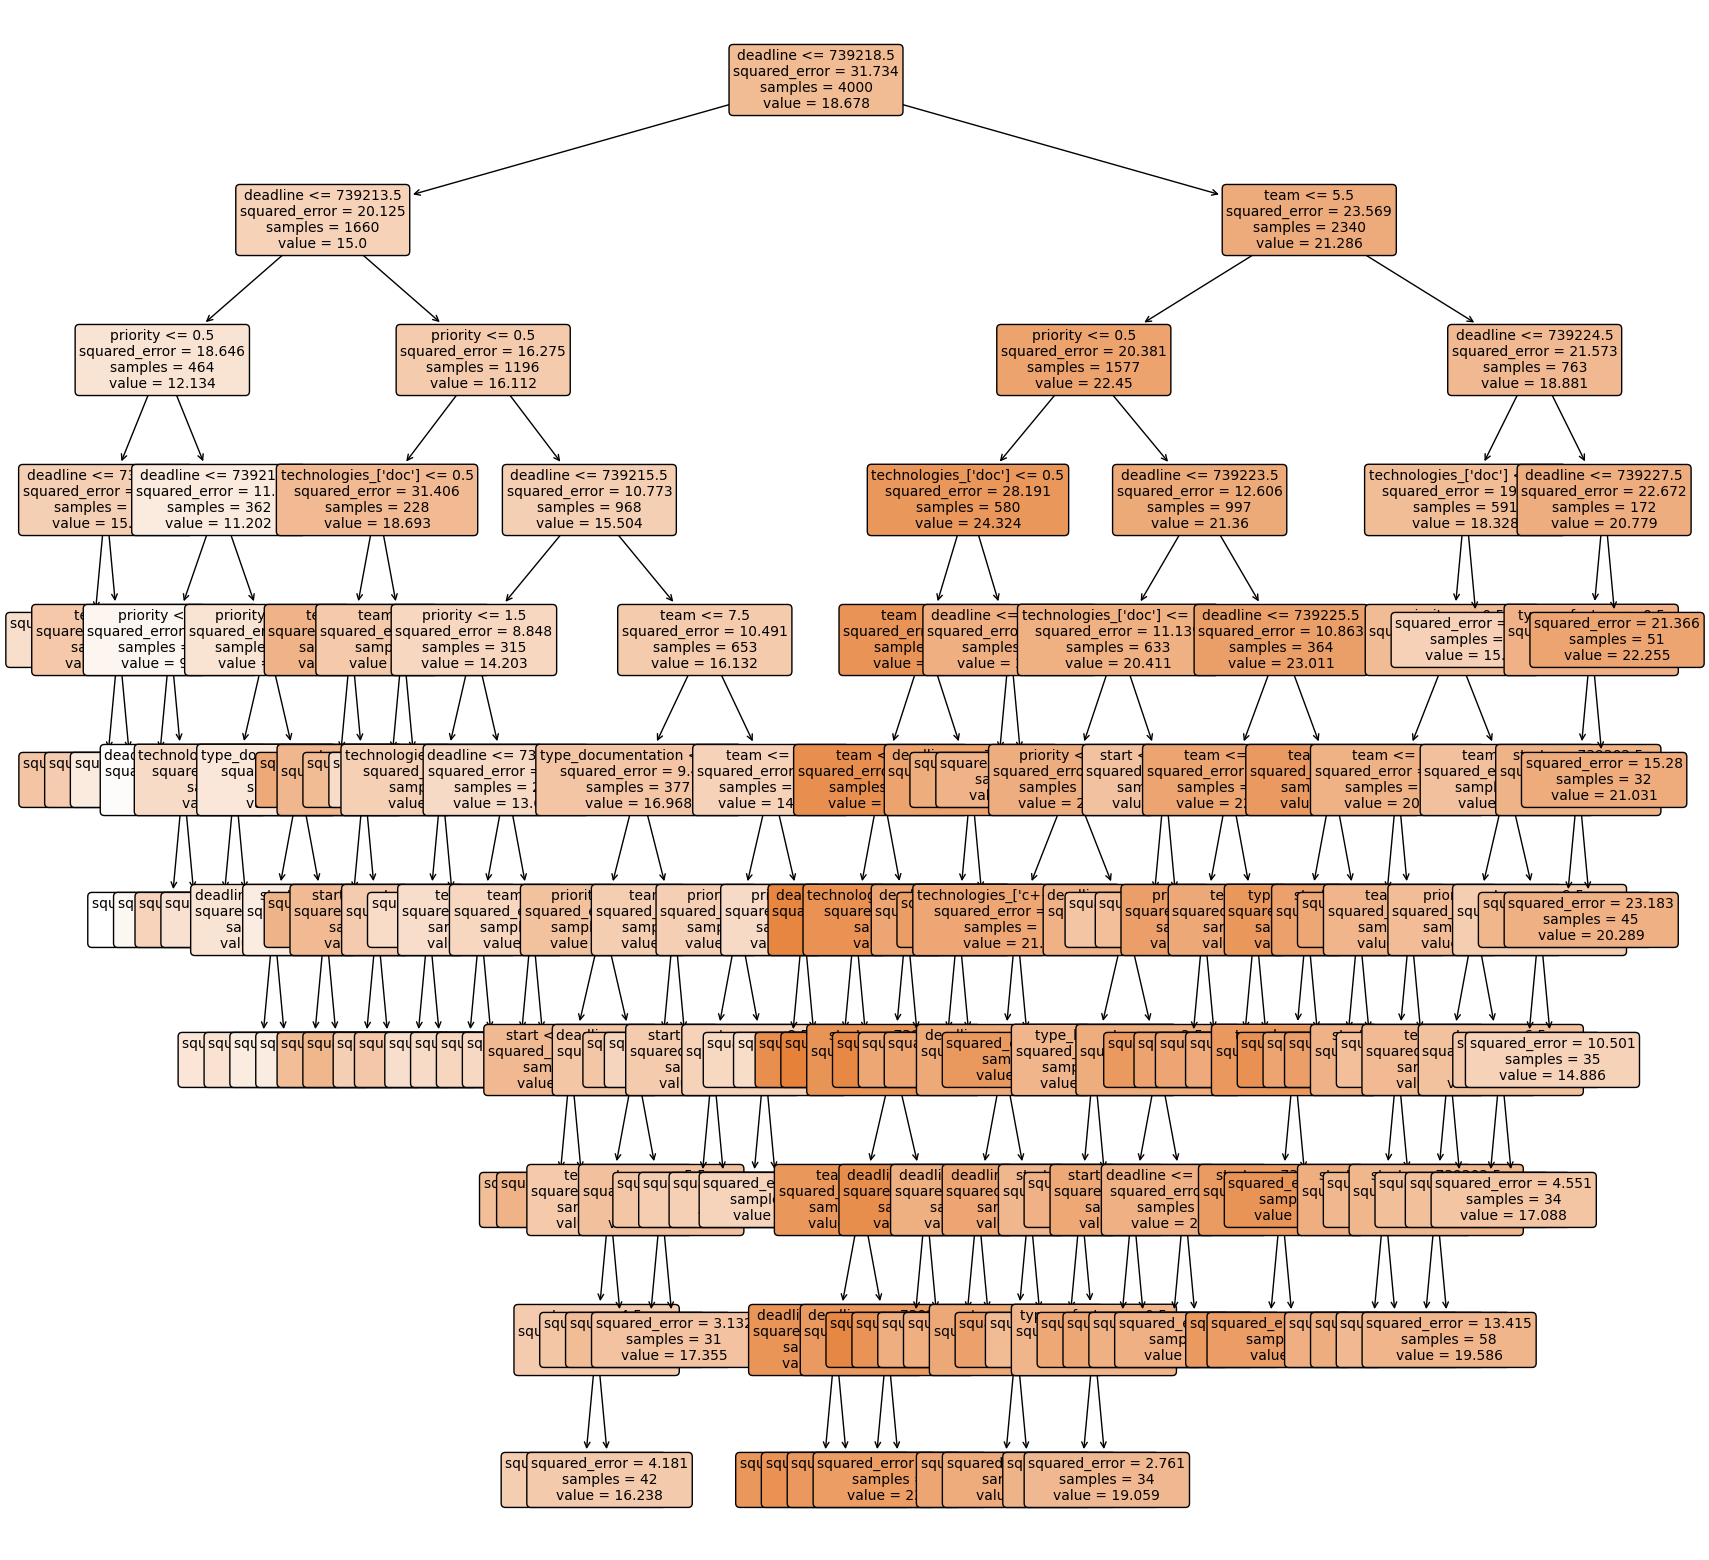

,start,deadline,team,priority,duration,predicted_duration_with_tree,diff_with_tree
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,739202.486400,739219.839000,5.532000,1.015800,18.625200,18.609600,2.946000
std,1.110703,5.435199,2.881152,0.813193,5.620271,4.270086,2.252221
min,739201.000000,739203.000000,1.000000,0.000000,1.000000,8.000000,0.000000
25%,739201.000000,739216.000000,3.000000,0.000000,15.000000,15.000000,1.000000
50%,739202.000000,739220.000000,6.000000,1.000000,19.000000,19.000000,2.000000
75%,739203.000000,739223.000000,8.000000,2.000000,22.000000,22.000000,4.000000
max,739204.000000,739237.000000,10.000000,2.000000,36.000000,28.000000,12.000000


In [ ]:
#split data between training and test sets

X = df_encoded.drop(columns=["duration", "desc"])
y = df_encoded["duration"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#lets use decision tree regressor
tree_reg = DecisionTreeRegressor()



#Function in order to round the prediction to the nearest integer, in order to be use in the GridSearchCV and cross validation
def custom_mse(y_true, y_pred):
    y_pred_rounded = np.round(y_pred).astype(int)
    return mean_squared_error(y_true, y_pred_rounded)

# Wrap the custom scorer with make_scorer
custom_scorer = make_scorer(custom_mse, greater_is_better=False)


#grid search
param_grid = [
    {'max_depth': [2,3,4,5,10,15,20,30], 'min_samples_split': [2,3,4,5,10,15,20,30], 'min_samples_leaf': [1,2,5,10,15,20,30]}
]
grid_search = GridSearchCV(tree_reg, param_grid, cv=5, scoring=custom_scorer, return_train_score=True)
grid_search.fit(X_train, y_train)
print("Best parameters : ", grid_search.best_params_)
#final model
final_model = grid_search.best_estimator_
final_predictions = final_model.predict(X_test)
#round predictions to the nearest integer because duration is an integer
final_predictions = np.round(final_predictions).astype(int)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print("Final RMSE : ", final_rmse)

#cross validation
scores = cross_val_score(final_model, X_train, y_train, scoring=custom_scorer, cv=10)
final_rmse_scores = np.sqrt(-scores)
print("Final RMSE scores : ", final_rmse_scores)
print("Final RMSE scores mean : ", final_rmse_scores.mean())
print("Final RMSE scores std : ", final_rmse_scores.std())

#show the tree
# dot_data = export_graphviz(final_model, out_file=None, feature_names=X.columns, filled=True, rounded=True, special_characters=True)
# graph = graphviz.Source(dot_data)
# graph.render("./data/task_duration_tree")

#temporary this one 
plt.figure(figsize=(20, 20))
plot_tree(final_model, feature_names=X.columns, filled=True, rounded=True, fontsize=10)
plt.show()
#now lets put the rounded predict duration in the dataset

df_encoded["predicted_duration_with_tree"] = np.round(final_model.predict(X)).astype(int)
df_encoded["diff_with_tree"] = df_encoded["duration"] - df_encoded["predicted_duration_with_tree"]
df_encoded["diff_with_tree"] = df_encoded["diff_with_tree"].abs()
#save it to a csv
df_encoded.to_csv("./data/tasks_with_predictions.csv", index=False)
df_encoded.describe()